# Real Robot Experiment

This notebook explains how we train the model for nut screwing task. For inference, we will visualize the results instead of actually running them because real robot setup is required for this task.

Before the details, I want to share some lessons learned from the real robot experiment.

1. **Use visually grounded prediction.** Robotics tasks are so prone to overfitting. The reasons are (1) scarse data (2) the mapping from an image to low-level robot actions is so arbitrary and fragile.
    > For example, in this task, we not only derive 3d positions from 2d pixel coordinate prediction (like what RVT has been doing). We also derive rotation from 2d prediction. In short, we predict multiple visual 2d points (not just one), and find the best possible 3d position and rotation through optimizing a 3D to 2D projection. It's a simple implementation but an interesting one. You will find the details in this notebook.


2. **Use Force feedback and Adjustment.** Human does not screw a nut in a single trial by looking at them once. We adjust the position and angles continuously and sense force feedback. There is a major line of work called Residual Reinforcement Learning, which basically learns to adjust or explore from coarse actions using RL. 
    > - In this task, we adopt the same principle, by defining a "adjust" command.
    > - We do not use the force feedback in our network input, but only use force to stop unsuccessful insertion (impedance control). Since an unsuccessful insertion mostly looks differently than a successful one, the network can learn the adjustment using the visual feedback.

In [dataset.py](dataset.py) and [network.py](network.py), you can find the details of how we represent the task data and the model. More details are provided when we run the pre-trained model step by step, and visualize the result. 

# Prepare Data and Pretrained Model

In [1]:
%mkdir -p data weights

Download `datasets/real-robot/demonstrations.zip` from the box folder https://rutgers.box.com/s/uzozemx67kje58ycy3lyzf1zgddz8tyq, and unzip it to the above `real-robot/data` folder.


Download `weights/real-robot/model_00003000.pth` from the box folder, and put it to the above `real-robot/weights` folder.

# Training

The following command will train the model, and evaluate it on validation set every 1000 iterations. The model will be saved to `outputs/default/${timestamp}` folder. Note I choose the model at iteration 3000 because it has the best performance on the validation set.

```bash
cd real-robot/
python3 train.py config=./config.yaml   
```

# Run the Pre-trained Model

In [2]:
from dataset import RealRobotDataset, load_pkl, SCENE_BOUNDS
import torch
from utils.vis import im_concat
torch.set_grad_enabled(False)
import numpy as np
from omegaconf import OmegaConf
from utils import load_hydra_config
from network import RobotPolicy, place_pc_in_cube

from copy import deepcopy
from PIL import Image, ImageDraw
from scipy.spatial.transform import Rotation as R
import random

def draw_dots(dots, images, color):
    dot_radius = 3
    dots = dots.reshape(-1, robot_policy.num_cameras, 2)
    for a in range(len(dots)):
        for b in range(robot_policy.num_cameras):
            im = images[b]
            draw = ImageDraw.Draw(im)
            x, y = dots[a, b].long().tolist() 
            draw.ellipse((x - dot_radius, y - dot_radius, x + dot_radius, y + dot_radius), fill=color)
    return dots
        
def visualize_results(r):
    imgs = deepcopy(r['pil_images'])
    if 'gripper_points' in r:
        draw_dots(r['gripper_points']['2d'], imgs, (0, 255, 0))

    if 'curr_wrench_points' in r:
        draw_dots(r['curr_wrench_points'], imgs, (255, 0, 0))
        draw_dots(r['wrench_points']['2d'], imgs, (0, 0, 255))
    else:
        if 'wrench_points' in r:
            draw_dots(r['wrench_points']['2d'], imgs, (255, 0, 0))
    return im_concat(*imgs)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


These episodes are not seen during training. 

In [3]:
eval_episodes = [51, 26, 70, 54, 29, 30, 47, 40, 53, 24]
device = 0

In [4]:
D = RealRobotDataset('./data/demonstrations', eval_episodes)

for e in D.episodes:
    print(e.id, [s['image_id'] for s in e.states])

processing:   0%|          | 0/31 [00:00<?, ?it/s]

51 [0, 2, 5]
26 [0, 2, 3, 5]
70 [0, 3, 6]
54 [0, 2, 4]
29 [0, 3, 4, 6]
30 [0, 2, 3, 5]
47 [0, 2, 3, 4]
40 [0, 3]
53 [0, 3]
24 [0, 3]


Load the model

In [5]:
cfg = OmegaConf.load('./config.yaml')
robot_policy = RobotPolicy(cfg.model, device)
ckpt = torch.load('weights/model_00003000.pth')
robot_policy.load_state_dict(ckpt)
robot_policy = robot_policy.to(device)
robot_policy = robot_policy.eval()

In the following, we have three images in one episode. The model is expected to predict "reach", "adjust", "rotate" commands for each image. 

In [6]:
# reach
Episode = 51
ImageId = 0
REACH_RGB_PATH = f'data/demonstrations/{Episode}/00{ImageId}.rgb.png'
REACH_DEP_PATH = f'data/demonstrations/{Episode}/00{ImageId}.depth.png'
REACH_STATE_PATH = f'data/demonstrations/{Episode}/00{ImageId}.state.pkl'

# adjust
Episode = 51
ImageId = 2
ADJUST_RGB_PATH = f'data/demonstrations/{Episode}/00{ImageId}.rgb.png'
ADJUST_DEP_PATH = f'data/demonstrations/{Episode}/00{ImageId}.depth.png'
ADJUST_STATE_PATH = f'data/demonstrations/{Episode}/00{ImageId}.state.pkl'

# rotate
Episode = 26
ImageId = 5
ROTATE_RGB_PATH = f'data/demonstrations/{Episode}/00{ImageId}.rgb.png'
ROTATE_DEP_PATH = f'data/demonstrations/{Episode}/00{ImageId}.depth.png'
ROTATE_STATE_PATH = f'data/demonstrations/{Episode}/00{ImageId}.state.pkl'

## REACH

Load the RGBD image, process into a point cloud that zoom in to the workspace

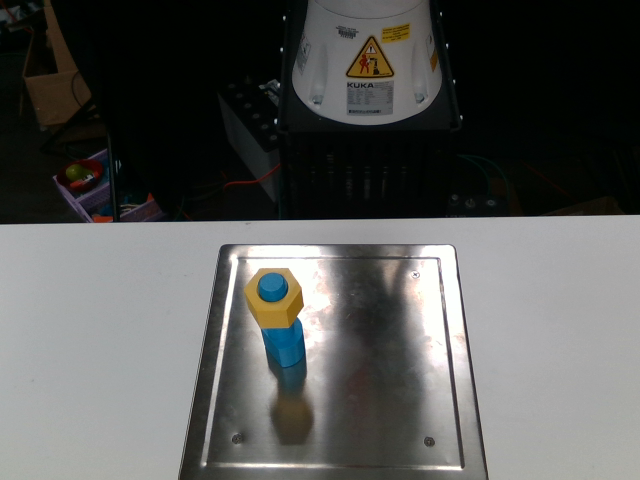

In [22]:
Image.open(REACH_RGB_PATH)

In [7]:
pcd = D.preprocess(REACH_RGB_PATH, REACH_DEP_PATH) 

Transform the current end-effector pose to the poses of a wrench and a "small" end-effector. 

The reason is that kuka robot's end-effector is too big to see in the image. In order to predict visually, we transform the poses of in-image objects, then transform them back to the robot's end-effector pose.

In [8]:
curr_eef_pose = load_pkl(open(REACH_STATE_PATH, 'rb'))['current_eef_pose']
wrench_pose, sm_eef_pose = D.full_gripper_to_wrench_and_small_gripper(curr_eef_pose)

Assemble batch

In [9]:
batch = {
    'points': np.asarray(pcd.points),
    'colors': np.asarray(pcd.colors),
    'curr_wrench': wrench_pose[:3],
    'curr_gripper': sm_eef_pose[:3]
}

batch = {k: torch.from_numpy(v).float().to(device) for k, v in batch.items()}

Let the robot policy decide what to do next:

In [10]:
cmd = robot_policy.predict_command(batch)
assert cmd == 'reach'
cmd

'reach'

Predict the low-level action values of this command:

In [11]:
batch['command'] = cmd
result = robot_policy.predict_detailed_actions(batch)

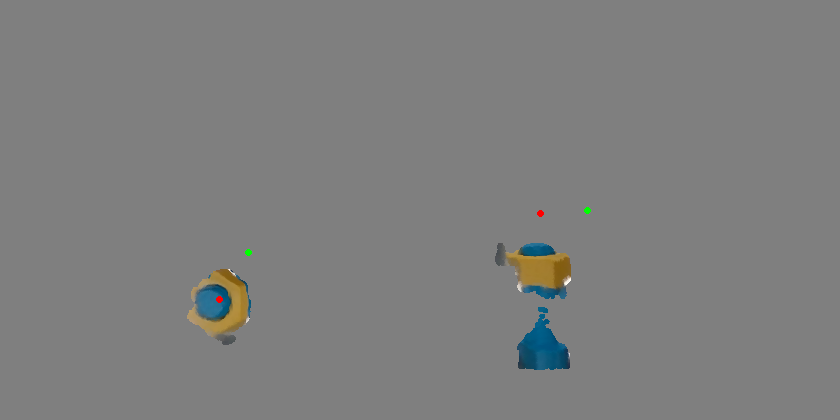

In [12]:
visualize_results(result)

The above figure visualize the wrench point (<span style="color:red">red</span>), and the "small" gripper point (<span style="color:green">green</span>). There are lots of blanks in the image because the images are re-rendered from point cloud, and we already crop the point cloud to only focus on the task-relevant areas. 

You can also directly run [dataset.py](dataset.py) in command line to generate visualization of the training data.

Next, we optimize a 3D to 2D projection to find the best 3D position and rotation of the actual gripper.

In [19]:
target_gripper_pose, estimation_err = D.to_target_full_gripper(result['wrench_points']['3d'].cpu().flatten(), 
                                                   result['gripper_points']['3d'].cpu().flatten())

print(f"EEF Pose (x,y,z,quaternion): {target_gripper_pose.round(5)}")
    
print('(3d to 2d) projection error (m):', estimation_err)

EEF Pose (x,y,z,quaternion): [0.58757 0.04474 0.43657 0.61972 0.78213 0.04155 0.05   ]
(3d to 2d) projection error (m): 0.0029304411128805736


# Adjust

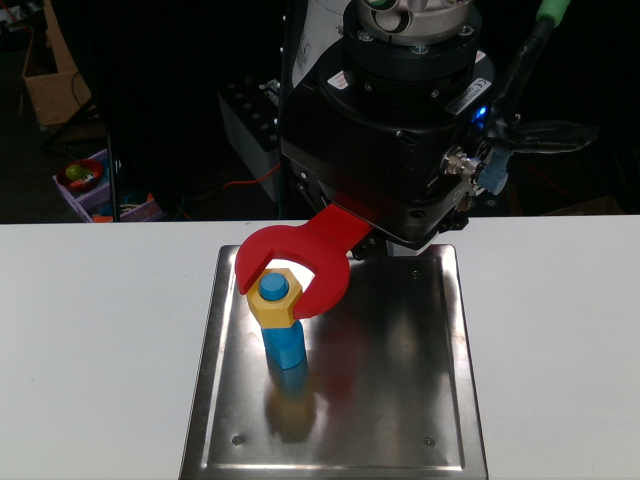

In [23]:
Image.open(ADJUST_RGB_PATH)

In [20]:
pcd = D.preprocess(ADJUST_RGB_PATH, ADJUST_DEP_PATH) 
curr_eef_pose = load_pkl(open(ADJUST_STATE_PATH, 'rb'))['current_eef_pose']
wrench_pose, sm_eef_pose = D.full_gripper_to_wrench_and_small_gripper(curr_eef_pose)

batch = {
    'points': np.asarray(pcd.points),
    'colors': np.asarray(pcd.colors),
    'curr_wrench': wrench_pose[:3],
    'curr_gripper': sm_eef_pose[:3]
}

batch = {k: torch.from_numpy(v).float().to(device) for k, v in batch.items()}

In [21]:
cmd = robot_policy.predict_command(batch)
assert cmd == 'adjust'
cmd

'adjust'

In [24]:
batch['command'] = cmd
result = robot_policy.predict_detailed_actions(batch)

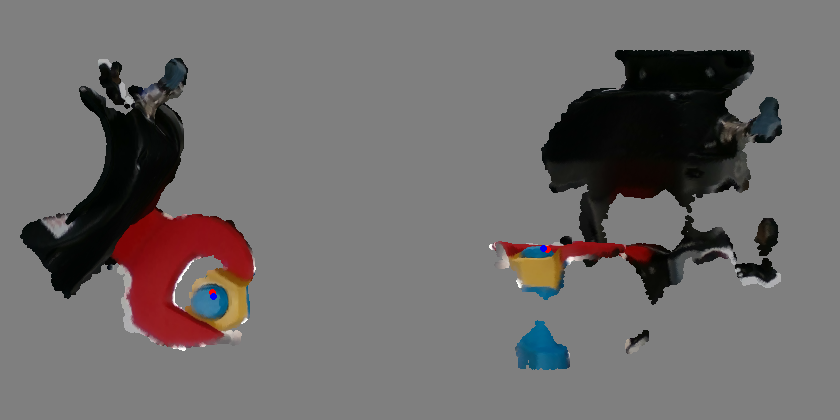

In [26]:
target_pts, _ = place_pc_in_cube(batch['points'], batch['curr_wrench'][:3].cuda().reshape(-1, 3),  with_mean_or_bounds=False, scene_bounds=SCENE_BOUNDS)
target_2d_pts = robot_policy.renderer.points3d_to_screen2d(target_pts[None, ...])
result['curr_wrench_points'] = target_2d_pts
visualize_results(result)

The above figure visualize the current wrench point (<span style="color:red">red</span>), and the expected adjusted wrench point (<span style="color:blue">blue</span>).

On our real robot, the adjusted wrench point is transformed to a horizontal direction of left or right, based on the relative position of the current wrench point. We always adjust for 3mm. This seems a bit simple, but it works ok. For example, the direction of this shown figure, is to the right. 

Note that we do not directly predict a "left" or "right" command. We predict the adjusted wrench point, a visually grounded prediction. During deployment, we still use a more robust left/right movement to adjust position. Directly predicting "left" or "right" leads to overfitting.

# Rotate

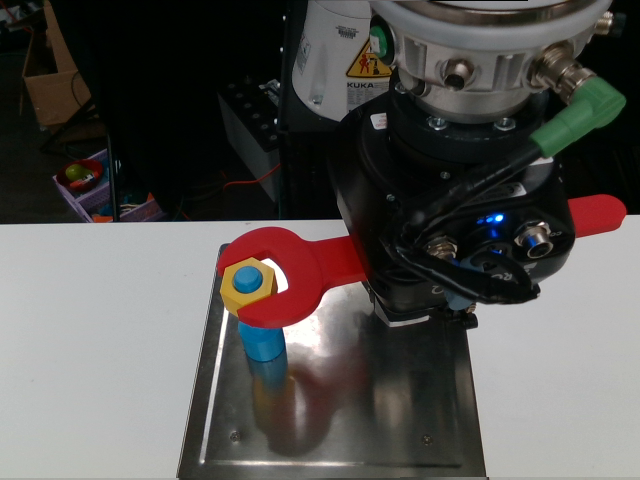

In [27]:
Image.open(ROTATE_RGB_PATH)

In [28]:
pcd = D.preprocess(ROTATE_RGB_PATH, ROTATE_DEP_PATH) 
curr_eef_pose = load_pkl(open(ROTATE_STATE_PATH, 'rb'))['current_eef_pose']
wrench_pose, sm_eef_pose = D.full_gripper_to_wrench_and_small_gripper(curr_eef_pose)

batch = {
    'points': np.asarray(pcd.points),
    'colors': np.asarray(pcd.colors),
    'curr_wrench': wrench_pose[:3],
    'curr_gripper': sm_eef_pose[:3]
}

batch = {k: torch.from_numpy(v).float().to(device) for k, v in batch.items()}

In [29]:
cmd = robot_policy.predict_command(batch)
assert cmd == 'rotate'
cmd

'rotate'

In [30]:
batch['command'] = cmd
result = robot_policy.predict_detailed_actions(batch)

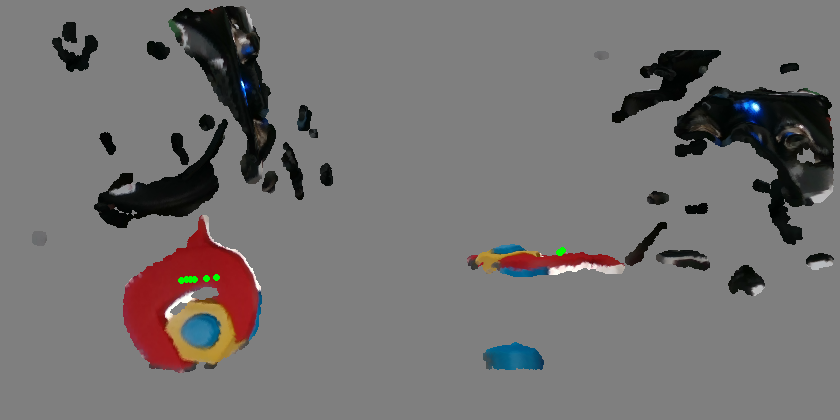

In [31]:
visualize_results(result)

The above figure visualize the "small" gripper points  (<span style="color:green">green</span>) for the rotation. We assume the wrench point is fixed. 